# Negative News Neural Nets Project: Classifying Adverse Media Articles using Machine Learning Algorithms

In this notebook, conda environment with Python 3.86 is used. Some libraries, such as spacy and nltk may require installation if your machine does not have them. 

You can use the steps below to install spaCy. If something goes awry, feel free to use pip/do some stackoverflow search to complete the installation. The last two parts will be required later on in the notebook, they are not essential spaCy packages.

 - conda install -c conda-forge spacy
 
 - conda install -c conda-forge spacy-lookups-data
 
 - python -m spacy download en_core_web_sm
 
 - pip install spacy-langdetect
 
 - conda install -c conda-forge wordcloud
 
On the other hand, installing nltk packages will be easy, just look at the error to understand what needs to be downloaded using nltk.download(...). I have already provided the download code for punkt package and I don't think anything is required beside that.

## TF-IDF & Naive Bayes Model

This will be a short notebook, reserved only for the Naive Bayes Model. We will use the cleaned & lemmatized dataset that we have exported as a .csv file during the preprocessing part.

In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
import pandas as pd
import numpy as np
import json
import math
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, f1_score, confusion_matrix

import scipy
from scipy.sparse import hstack

# This module will be for saving the trained model for later use
import joblib

In [3]:
# Uncomment this if you're using linux
# !ls 

In [4]:
# Let's get an overview of what our folder contains..
!dir

 Volume in drive C is Win 10
 Volume Serial Number is CA9A-F06E

 Directory of C:\Users\canberk\Desktop\ut-ml-adverse-media-main

12/08/2020  07:23 AM    <DIR>          .
12/08/2020  07:23 AM    <DIR>          ..
11/23/2020  06:08 PM           110,455 .ipynb
12/08/2020  06:59 AM    <DIR>          .ipynb_checkpoints
11/21/2020  04:43 PM         3,752,073 adverse_media_training.csv.zip
12/08/2020  06:39 AM         2,174,223 cleaned_lemmatized_text.csv
12/08/2020  06:07 AM           110,996 Data Preprocessing&Baselines-Original.ipynb
12/08/2020  06:06 AM           115,641 Data Preprocessing&Baselines.ipynb
11/21/2020  04:43 PM         3,630,748 EDA - Kristjan's Original.ipynb
11/23/2020  06:04 PM         3,740,422 EDA.ipynb
10/24/2015  07:35 PM     5,646,236,541 glove.840B.300d.txt
12/07/2020  04:36 PM     2,176,768,927 glove.840B.300d.zip
11/21/2020  04:43 PM             1,073 LICENSE
12/08/2020  07:16 AM            28,351 Logistic Regression.ipynb
12/08/2020  07:13 AM            54,634 

In [5]:
df = pd.read_csv('./cleaned_lemmatized_text.csv')
df.head()

,is_adverse_media,lemmatized_articles
0,0,zimbabweans wake news agriculture minister per...
1,1,singapore founder singapore oil trade company ...
2,1,fraudster offer green tax efficient investment...
3,1,buenos aire reuter judicial probe possible cor...
4,0,ukraines constitutional court appear strike bl...


In [6]:
x_train, x_val, y_train, y_val = train_test_split(df['lemmatized_articles'], 
                                                    df['is_adverse_media'], 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    stratify=df['is_adverse_media'])

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(656,) (73,) (656,) (73,)


In [7]:
x_train.head()

26     late september joe tone young editor dallas ob...
257    mexicos attorney general alejandro gertz maner...
0      zimbabweans wake news agriculture minister per...
279    article write yash singhal vivekananda institu...
108    singapore reuters singapores central bank impo...
Name: lemmatized_articles, dtype: object

The train and validation sets are ready for applying a vectorizer function. Instead of creating the document-term matrix by simply counting the number of occurrences of words(ie bag of words approach), I will apply a tf-idf vectorizer on train data.

In [8]:
ngram_vectorizer = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word', 
                             stop_words='english', 
                             ngram_range=(1, 3))
print(ngram_vectorizer)

TfidfVectorizer(max_df=0.5, max_features=40000, min_df=5, ngram_range=(1, 3),
                stop_words='english')


Let's fit the vectorizer to x_train and take a look at the feature names.

In [9]:
import random
ngram_vectorizer.fit(x_train)
features = ngram_vectorizer.get_feature_names()

random.sample(features, k=20)

['yorks',
 'woman',
 'rural',
 'involved',
 'laboratory',
 'subprime',
 'air',
 'equity',
 'tax evasion charge',
 'foreign asset',
 'shooting',
 'unknown',
 'highlevel',
 'asset jurisdiction',
 'federal police',
 'director company',
 'case people',
 'profession',
 'moneylaundere',
 'base']

In [10]:
tfidf_train = ngram_vectorizer.transform(x_train)
tfidf_validation = ngram_vectorizer.transform(x_val)

In [11]:
doc_array = tfidf_train.toarray()
doc_array

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.1394311 , 0.07193199,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [12]:
frequency_matrix = pd.DataFrame(doc_array, 
                                columns = features)
frequency_matrix.head(10)

,abandon,abdul,abdullah,abide,ability,able,able use,abolish,abroad,absence,...,zanupf,zealand,zero,zetas,zimbabwe,zimbabwe anticorruption,zimbabwe anticorruption commission,zimbabwean,zimbabwes,zone
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.074467,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.129174,0.0,0.0,0.139431,0.071932,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.016777,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
6,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
8,0.0,0.0,0.0,0.0,0.0,0.014276,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


Both the train and the validation datasets are transformed. Now we need to fit a naive bayes model to see how far it can get with f1 score and accuracy.

### Second Baseline Model: Naive Bayes

I will provide some helper functions for tuning the Naive Bayes model here, since it requires only one parameter, alpha, to tune.

Hopefully Naive Bayes will result in a high f1 score.

In [13]:
def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(model, tfidf_train, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Here we will check the AUC scores and see what smoothing parameter works the best for lutinomial naive bayes. It may look weird that we have used cross validation above even though we have a validation dataset already, but think of the latter as the public test for now.

Best alpha:  0.3


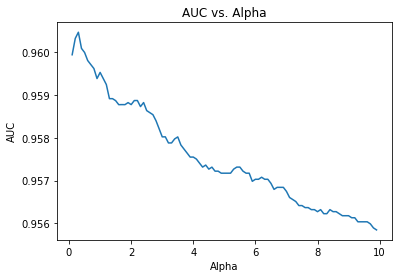

In [14]:
res = pd.Series([get_auc_CV(MultinomialNB(alpha = i))
                 for i in np.arange(0.1, 10, 0.1)],
                index=np.arange(0.1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [15]:
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9474
Accuracy: 87.67%


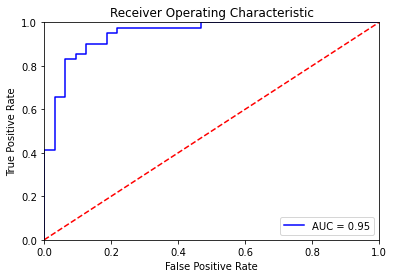

In [16]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(tfidf_train, y_train)
probs = nb_model.predict_proba(tfidf_validation)

# Evaluate the classifier
evaluate_roc(probs, y_val)

In [17]:
train_preds_nb = nb_model.predict(tfidf_train)
val_preds_nb = nb_model.predict(tfidf_validation)

train_f1_score_nb = f1_score(y_train, train_preds_nb)
val_f1_score_nb = f1_score(y_val, val_preds_nb)

train_accuracy_nb = accuracy_score(y_train, train_preds_nb)
val_accuracy_nb = accuracy_score(y_val, val_preds_nb)

In [18]:
print('Prediction accuracy for naive bayes model on train data:', round(train_accuracy_nb*100, 3))
print('Prediction accuracy for naive bayes model on validation data:', round(val_accuracy_nb*100, 3))

print()

print('F1 score for naive bayes model on train data:', round(train_f1_score_nb*100, 3))
print('F1 score for naive bayes model on validation data:', round(val_f1_score_nb*100, 3))

Prediction accuracy for naive bayes model on train data: 96.951
Prediction accuracy for naive bayes model on validation data: 87.671

F1 score for naive bayes model on train data: 97.312
F1 score for naive bayes model on validation data: 89.655


The high F1 score is a nice start, but one can do better. Let's save the untuned NB model for later modifications.

In [19]:
filename = 'naive_bayes_model.sav'
joblib.dump(nb_model, filename)

['naive_bayes_model.sav']

In [21]:
#loaded_model = joblib.load(filename)
#val_preds_lr = loaded_model.predict(tfidf_validation)
#result = f1_score(y_val, val_preds_lr)
#print(result)